#En esta primera parte cargaremos los datos y crearemos el subset que guardaremos como "datos_extraidos.csv" para realizar nuetros procedimientos.

En github se guardará el archivo  "datos_extraidos.csv" y los que se generen para ejecutar los otros notebooks, el código puede ejecutarse desde el punto donde se carga el archivo mencionado.

In [1]:
import gzip
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creación de un subset de datos:
Se definen rutas para el dataset completo y un subset.
Se crea un subset del archivo original 'Books.jsonl.gz' tomando las primeras 100,000 líneas y guardándolas en un nuevo archivo comprimido 'subset_Books.jsonl.gz'

In [3]:
# Definir la ruta al archivo completo y al subset
full_dataset_path = '/content/drive/MyDrive/NLP/Books.jsonl.gz'
subset_path = '/content/drive/MyDrive/NLP/subset_Books.jsonl.gz'

# Crear un nuevo archivo para el subset
with gzip.open(full_dataset_path, 'rt', encoding='utf-8') as f_in, \
     gzip.open(subset_path, 'wt', encoding='utf-8') as f_out:

# Evita cargar todo el archivo en memoria, procesando las líneas una por una
    for i, line in enumerate(f_in):
        if i < 100000:  # Cargar solo las primeras 100000 líneas
            f_out.write(line)  # Escribir la línea directamente en el nuevo archivo
        else:
            break



Debido a limitaciones de tiempo y recursos computacionales, nos vimos en la necesidad de trabajar con una muestra representativa de las reseñas disponibles. En este proceso, nos enfocamos principalmente en seleccionar reseñas con sentimientos claramente positivos o negativos, excluyendo aquellas de carácter neutral. Esta estrategia nos permitió optimizar el análisis y concentrarnos en los casos más relevantes para nuestro estudio de polaridad de opiniones.

# Descompresión y carga de datos:
Se descomprime el subset creado a un archivo  'uncompressed_subset_Books.jsonl'
Se carga un DataFrame de pandas.
Se filtra el DataFrame para incluir solo las reseñas con calificaciones de 1, 2, 4 y 5.
Se realiza un muestreo equilibrado, seleccionando 2000 muestras aleatorias para cada una de estas calificaciones en un nuevo DataFrame llamado 'df_subset'.

In [4]:
# Definir la ruta al archivo comprimido del subset
subset_path = '/content/drive/MyDrive/NLP/subset_Books.jsonl.gz'
uncompressed_subset_path = '/content/drive/MyDrive/NLP/uncompressed_subset_Books.jsonl'

# Descomprimir el archivo del subset
with gzip.open(subset_path, 'rt', encoding='utf-8') as f_in:
    with open(uncompressed_subset_path, 'w', encoding='utf-8') as f_out:
        f_out.write(f_in.read())  # Leer y escribir todo el contenido

# Cargar el archivo descomprimido en un DataFrame
df = pd.read_json(uncompressed_subset_path, lines=True)

filtered_df = df[df['rating'].isin([1, 2, 4, 5])]

num_samples = 2000
sampled_df_1 = filtered_df[filtered_df['rating'] == 1].sample(n=num_samples)
sampled_df_2 = filtered_df[filtered_df['rating'] == 2].sample(n=num_samples)
sampled_df_4 = filtered_df[filtered_df['rating'] == 4].sample(n=num_samples)
sampled_df_5 = filtered_df[filtered_df['rating'] == 5].sample(n=num_samples)

df_subset_total = pd.concat([sampled_df_1, sampled_df_2, sampled_df_4, sampled_df_5])

In [5]:
# Verificar las columnas disponibles
print('Columnas disponibles',df_subset_total.columns)

Columnas disponibles Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


Guardamos el archivo

In [6]:
# Mantener solo las columnas 'text' y 'rating'
df_subset = df_subset_total[['text', 'rating']]

Guardamos el subset para ser utilizado en nuestros procesos

In [ ]:
df_subset.to_csv('/content/drive/My Drive//NLP/datos_extraidos.csv', index=False)

## Desde este punto se puede ejecutar el código.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

#Cargamos el subset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_subset = pd.read_csv('/content/drive/MyDrive/NLP/datos_extraidos.csv')

In [4]:
# Verificar las primeras filas del DataFrame
print(df_subset.head())

# Información general sobre el DataFrame
print(df_subset.info())

# Estadísticas descriptivas básicas
print(df_subset.describe())
# Contar el número total de reseñas en el subconjunto
print(f"Número total de reseñas: {len(df_subset)}")

# Verificar si hay valores nulos
print('Valores nulos')
print(df_subset.isnull().sum())

                                                text  rating
0  This is a very warped story about the author/B...       1
1  Grandma bought this book at a brick and mortar...       1
2  worst woods book i've read. and i have read th...       1
3  Boring and flat.  Couldn't wait to finish it t...       1
4  Don't waste your money on this deeply unhelpfu...       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8000 non-null   object
 1   rating  8000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 125.1+ KB
None
            rating
count  8000.000000
mean      3.000000
std       1.581238
min       1.000000
25%       1.750000
50%       3.000000
75%       4.250000
max       5.000000
Número total de reseñas: 8000
Valores nulos
text      0
rating    0
dtype: int64


La calidad de los datos es excelente, sin valores nulos en las columnas 'text' y 'rating'. El conjunto de datos contiene 8000 reseñas equilibradas, con 2000 reseñas para cada calificación (1, 2, 4 y 5 estrellas). La media de calificación es de 3.0, con una desviación estándar de 1.58, lo que indica una buena distribución de opiniones. Este conjunto de datos proporciona una base sólida y balanceada para llevar a cabo un análisis de sentimiento efectivo, permitiendo una comparación equitativa entre reseñas positivas y negativas.

Cardinalidad del vocabulario: 35604


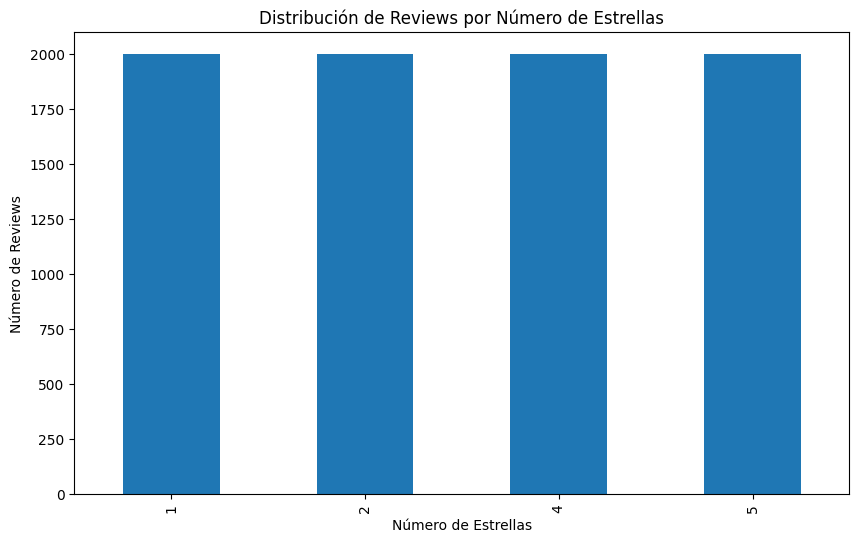

Número de reviews positivas: 4000
Número de reviews negativas: 4000


In [5]:
# 1. Cardinalidad del vocabulario
vectorizer = CountVectorizer()
vectorizer.fit(df_subset['text'])
vocab_cardinality = len(vectorizer.get_feature_names_out())
print(f'Cardinalidad del vocabulario: {vocab_cardinality}')

# 2. Distribución de reviews por número de estrellas
plt.figure(figsize=(10, 6))
df_subset['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Número de Estrellas')
plt.ylabel('Número de Reviews')
plt.show()

# 3. Número de reviews positivas y negativas
positive_reviews = df_subset[df_subset['rating'] >= 4].shape[0]
negative_reviews = df_subset[df_subset['rating'] <= 2].shape[0]

print(f'Número de reviews positivas: {positive_reviews}')
print(f'Número de reviews negativas: {negative_reviews}')

Las reseñas están perfectamente balanceadas entre positivas y negativas.
La alta cardinalidad del vocabulario (35,604 palabras únicas) sugiere que el conjunto de datos captura una amplia gama de expresiones y opiniones, lo cual es beneficioso para un análisis de sentimiento robusto.

Unigrams más frecuentes:
br: 21234
book: 12440
read: 4036
like: 3695
story: 3428
just: 3357
good: 2339
really: 2267
books: 2118
34: 2063

Bigrams más frecuentes:
br br: 9137
br book: 572
year old: 378
read book: 356
book br: 349
main character: 242
ve read: 224
don know: 198
like book: 194
reading book: 185


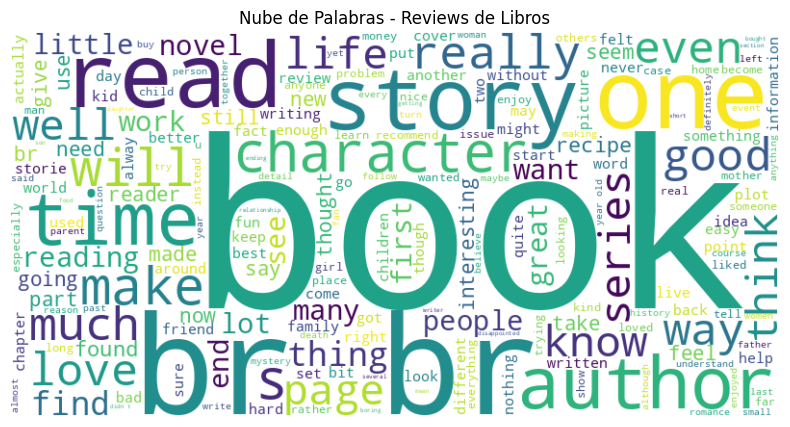

In [7]:
# Unigrams más frecuentes
unigram_vectorizer = CountVectorizer(stop_words='english')
unigrams = unigram_vectorizer.fit_transform(df_subset['text'])
unigram_counts = unigrams.sum(axis=0).A1
unigram_freq = [(word, unigram_counts[i]) for word, i in unigram_vectorizer.vocabulary_.items()]
unigram_freq_sorted = sorted(unigram_freq, key=lambda x: x[1], reverse=True)

print("Unigrams más frecuentes:")
for unigram, count in unigram_freq_sorted[:10]:
    print(f'{unigram}: {count}')

# Bigrams más frecuentes
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigrams = bigram_vectorizer.fit_transform(df_subset['text'])
bigram_counts = bigrams.sum(axis=0).A1
bigram_freq = [(word, bigram_counts[i]) for word, i in bigram_vectorizer.vocabulary_.items()]
bigram_freq_sorted = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

print("\nBigrams más frecuentes:")
for bigram, count in bigram_freq_sorted[:10]:
    print(f'{bigram}: {count}')

# Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_subset['text']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras - Reviews de Libros')
plt.show()

La palabra "br" aparece con alta frecuencia, indicando que hay elementos HTML no limpiados en los datos.Entre los unigrams, términos como "book", "read", "like", "story" y "good" destacan, lo que sugiere una alta relevancia del tema central, reflejando opiniones sobre la experiencia de lectura. En cuanto a los bigrams, "br br" es el más común, seguido de combinaciones significativas como "year old" y "read book", que indican temas recurrentes en las reseñas. Esto sugiere que es necesario realizar una limpieza adicional de datos para mejorar el análisis


Visualización de Word Embeddings con Word2Vec

Número de palabras válidas en el vocabulario: 5


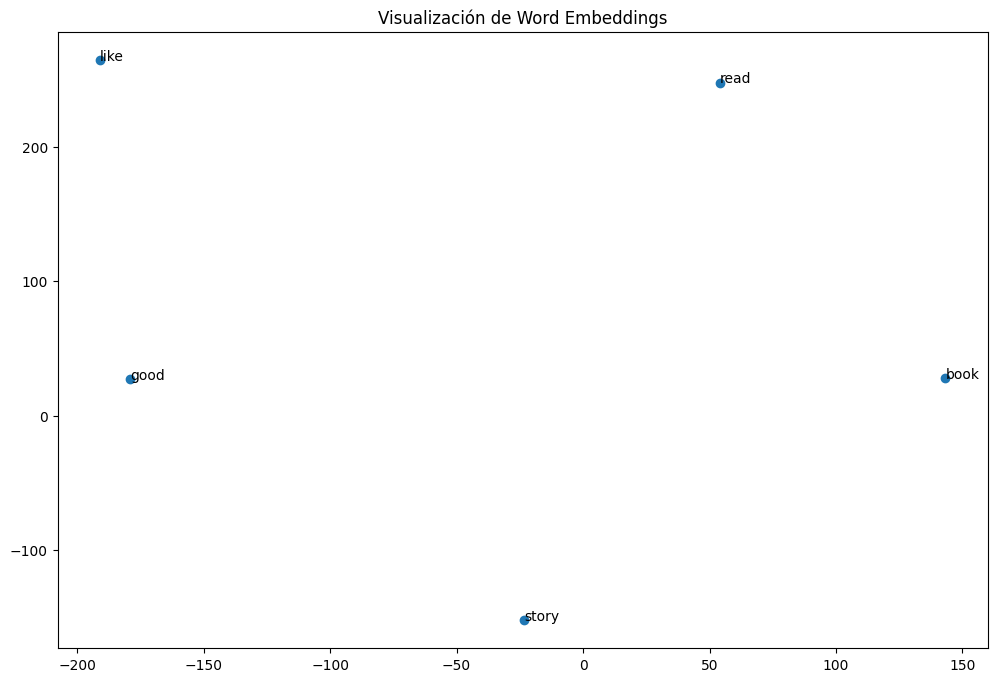


Palabras más similares a 'book':
['book,', 'novel', 'book.', 'story.', 'one.', 'story', 'series', 'cookbook', 'definitely', 'story,']

Palabras más similares a 'good':
['great', 'nice', 'fun', 'bad', 'interesting', 'decent', 'quite', 'cute', 'little', 'here']

Palabras más similares a 'story':
['story.', 'writing', 'novel', 'plot', 'story,', 'book', 'author', 'character', 'ending', 'book,']

Palabras más similares a 'read':
['reading', 'review,', 'bought', 'buy', 'try.', 'read.', 'purchased', 'CD,', 'series', 'series,']

Palabras más similares a 'like':
['feel', 'think', 'really', 'know.', 'thought', 'know', 'enjoy', 'appreciate', 'suppose', 'actually']


In [8]:
# Preparar las oraciones para Word2Vec
sentences = [review.split() for review in df_subset['text']]  # Usar el texto original

# Entrenar modelo Word2Vec
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Palabras de interés (puedes agregar más si es necesario)
palabras_interes = ['book', 'good', 'story', 'read', 'like']

# Verificar cuántas palabras están en el vocabulario
valid_words = [palabra for palabra in palabras_interes if palabra in model.wv.key_to_index]
print(f"Número de palabras válidas en el vocabulario: {len(valid_words)}")

# Función para encontrar palabras más similares
def palabras_similares(palabra, topn=10):
    try:
        similares = model.wv.most_similar(palabra, topn=topn)
        return [par[0] for par in similares]
    except KeyError:
        return []

# Visualización
def visualizar_embeddings(palabras):
    valid_words = [palabra for palabra in palabras if palabra in model.wv.key_to_index]
    if len(valid_words) < 2:
        print("No hay suficientes palabras válidas para visualizar.")
        return

    vectors = np.array([model.wv[palabra] for palabra in valid_words])

    # Reducir dimensionalidad con t-SNE
    tsne = TSNE(n_components=2, perplexity=min(5, len(valid_words)-1), random_state=42)  # Ajustar perplexity
    vectors_2d = tsne.fit_transform(vectors)

    # Graficar
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

    for i, palabra in enumerate(valid_words):
        plt.annotate(palabra, (vectors_2d[i, 0], vectors_2d[i, 1]))

    plt.title('Visualización de Word Embeddings')
    plt.show()

# Visualizar embeddings
visualizar_embeddings(palabras_interes)

# Imprimir palabras más similares
for palabra in palabras_interes:
    print(f"\nPalabras más similares a '{palabra}':")
    print(palabras_similares(palabra))


El análisis de las palabras más similares a términos clave en las reseñas de libros revela patrones significativos en el lenguaje utilizado por los revisores. Las palabras relacionadas con 'book' como 'novel', 'series' y 'story' destacan la relevancia del contenido literario, mientras que las similitudes con 'good', que incluyen tanto términos positivos como negativos, indican un espectro variado de opiniones sobre la calidad de los libros. Los términos asociados a 'story' reflejan aspectos narrativos importantes, y las palabras similares a 'read' capturan el ciclo de interacción del lector con el libro. Además, las similitudes con 'like' muestran cómo los revisores expresan sus emociones y recomendaciones. Sin embargo, la presencia de palabras con puntuación sugiere la necesidad de una limpieza adicional de datos para mejorar la precisión del análisis. En conjunto, estos hallazgos ofrecen una comprensión rica y matizada de las opiniones sobre libros en el conjunto de datos.

Con base en estos hallazgos, debemos proceder con un preprocesamiento exhaustivo del texto para limpiar los datos y preparar un conjunto adecuado para el modelado de análisis de sentimientos. Esto incluirá la eliminación de stopwords, la lematización y la tokenización, lo cual permitirá obtener representaciones más precisas del contenido textual.

In [9]:
# Guardar como CSV en Google Drive
df_subset.to_csv('/content/drive/My Drive//NLP/datos_explorados.csv', index=False)